In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from cbrain.utils import limit_memmem

In [2]:
limit_mem()

In [3]:
import keras
from keras.layers import *
from keras.models import Model, Sequential

## MNIST AE

In [6]:
from keras.datasets import mnist

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)

In [12]:
x_train.shape

(60000, 784)

In [13]:
x_train, x_test = x_train/255, x_test/255

In [30]:
def show_imgs(x):
    fig, axs = plt.subplots(1, 5)
    for i, ax in enumerate(axs.flat):
        ax.imshow(x[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

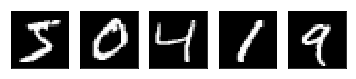

In [31]:
show_imgs(x_train)

In [41]:
inp = Input(shape=(784,))
enc = Dense(10, activation='elu')(inp)
out = Dense(784, activation='sigmoid')(enc)
model = Model(inp, out)

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile('adam', 'binary_crossentropy')

In [44]:
model.fit(x_train, x_train, epochs=30, batch_size=256, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 32us/step - loss: 0.3372 - val_loss: 0.2587
Epoch 2/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.2348 - val_loss: 0.2139
Epoch 3/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.2031 - val_loss: 0.1920
Epoch 4/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1900 - val_loss: 0.1859
Epoch 5/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1860 - val_loss: 0.1833
Epoch 6/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1840 - val_loss: 0.1818
Epoch 7/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1829 - val_loss: 0.1808
Epoch 8/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.1820 - val_loss: 0.1802
Epoch 9/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1815 - val_loss: 0.1796
Epoch

In [45]:
preds = model.predict(x_test, 1024)

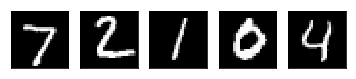

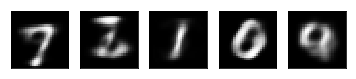

In [46]:
show_imgs(x_test)
show_imgs(preds)

## CBRAIN workflow

In [47]:
from cbrain.data_generator import *

In [48]:
DATADIR = '/local/S.Rasp/preprocessed_data/'

In [63]:
train_fn = 'fbp_engy_ess_train_sample1_shuffle'
valid_fn = 'fbp_engy_ess_valid_sample1'
norm_fn = 'fbp_engy_ess_train_sample1_norm.nc'

In [50]:
bs = 512

In [52]:
trn_gen_obj = DataGenerator(
    DATADIR, train_fn + '_features.nc', train_fn + '_targets.nc', bs, norm_fn,
    fsub='feature_means', fdiv='feature_stds', tmult='target_conv',shuffle=True,
)
trn_gen = trn_gen_obj.return_generator()

Generator will have 23494656 samples in 45888 batches
Features have shape 94; targets have shape 65


In [86]:
val_gen_obj = DataGenerator(
    DATADIR, valid_fn + '_features.nc', valid_fn + '_targets.nc', bs, norm_fn,
    fsub='feature_means', fdiv='feature_stds', tmult='target_conv',shuffle=True,
)
val_gen = trn_gen_obj.return_generator()

Generator will have 23494656 samples in 45888 batches
Features have shape 94; targets have shape 65


In [87]:
true = np.concatenate([next(val_gen)[1] for i in range(20)])

In [53]:
x, y = next(trn_gen)

In [54]:
x.shape, y.shape

((512, 94), (512, 65))

In [56]:
ref_model = Sequential([
    Dense(256, input_shape=(x.shape[1],), activation='elu'),
    Dense(256, activation='elu'),
    Dense(y.shape[1], activation='linear')
])

In [57]:
ref_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               24320     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 65)                16705     
Total params: 106,817
Trainable params: 106,817
Non-trainable params: 0
_________________________________________________________________


In [58]:
ref_model.compile('adam', 'mse')

In [59]:
ref_model.fit_generator(trn_gen, trn_gen_obj.n_batches, epochs=1)

Epoch 1/1
45888/45888 [==============================] - 267s 6ms/step - loss: 0.0061


In [66]:
ref_model.evaluate_generator(val_gen, 20)

0.005579440575093031

In [83]:
preds = ref_model.predict_generator(val_gen, 20)

In [84]:
preds.shape

(10240, 65)

In [213]:
def show_cbrain(x_true, x_pred, random=True):
    fig, axs = plt.subplots(1, 5, figsize=(10, 5))
    for i, ax in enumerate(axs.flat):
        i = np.random.randint(0, len(x_pred)) if random else i
        ax.plot(x_true[i], label='true')
        ax.plot(x_pred[i], label='pred')
    axs[-1].legend()
    plt.tight_layout(); plt.show()

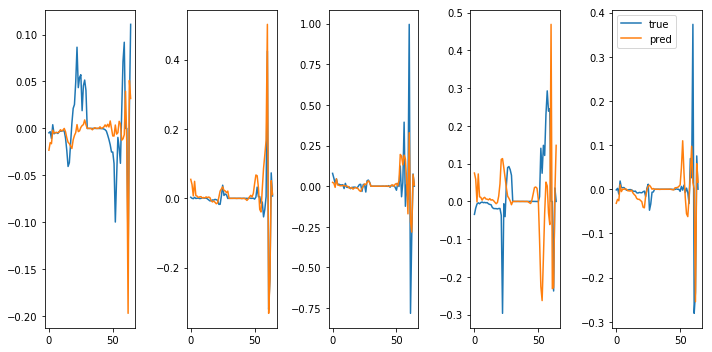

In [207]:
show_cbrain(true, preds)

## CBRAIN AE

In [93]:
model = Sequential([
    Dense(256, input_shape=(x.shape[1],), activation='elu'),
    Dense(10, activation='elu'),
    Dense(256, activation='elu'),
    Dense(y.shape[1], activation='linear')
])

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               24320     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               2816      
_________________________________________________________________
dense_18 (Dense)             (None, 65)                16705     
Total params: 46,411
Trainable params: 46,411
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.compile('adam', 'mse')

In [96]:
model.fit_generator(trn_gen, trn_gen_obj.n_batches, epochs=1)

Epoch 1/1
45888/45888 [==============================] - 258s 6ms/step - loss: 0.0061


In [97]:
model.evaluate_generator(val_gen, 20)

0.0057174216490238905

In [98]:
preds2 = ref_model.predict_generator(val_gen, 20)

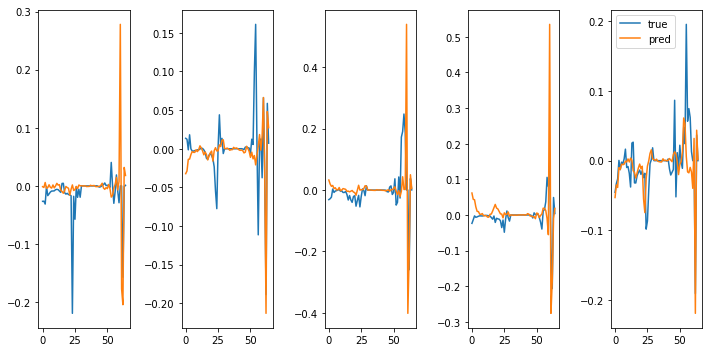

In [99]:
show_cbrain(true, preds2)

## VAE MNIST

In [112]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [114]:
latent_dim = 10
inputs = Input(shape=(784,))
x = Dense(256, activation='elu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')



latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(256, activation='elu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')


outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [115]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 256)          200960      input_12[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           2570        dense_29[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           2570        dense_29[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [116]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  206100    
_________________________________________________________________
decoder (Model)              (None, 784)               204304    
Total params: 410,404
Trainable params: 410,404
Non-trainable params: 0
_________________________________________________________________


In [117]:
from keras.losses import mse, binary_crossentropy

In [119]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


In [121]:
vae.fit(x_train, epochs=30, batch_size=256, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 40us/step - loss: 196.0094 - val_loss: 149.0853
Epoch 2/30
60000/60000 [==============================] - 2s 31us/step - loss: 145.1804 - val_loss: 140.8794
Epoch 3/30
60000/60000 [==============================] - 2s 31us/step - loss: 139.9110 - val_loss: 136.3278
Epoch 4/30
60000/60000 [==============================] - 2s 31us/step - loss: 135.5412 - val_loss: 132.2584
Epoch 5/30
60000/60000 [==============================] - 2s 31us/step - loss: 131.5816 - val_loss: 128.4293
Epoch 6/30
60000/60000 [==============================] - 2s 31us/step - loss: 128.2096 - val_loss: 125.4951
Epoch 7/30
60000/60000 [==============================] - 2s 31us/step - loss: 125.4682 - val_loss: 123.2077
Epoch 8/30
60000/60000 [==============================] - 2s 31us/step - loss: 123.2903 - val_loss: 121.2391
Epoch 9/30
60000/60000 [==============================] - 2s 31us/step - loss:

In [124]:
preds = vae.predict(x_test, 1024)
preds2 = vae.predict(x_test, 1024)

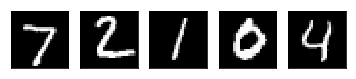

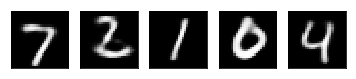

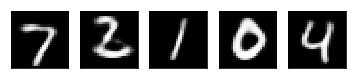

In [127]:
show_imgs(x_test)
show_imgs(preds)
show_imgs(preds2)

## VAE CBRAIN

In [129]:
x, y = next(trn_gen)
x.shape, y.shape

((512, 94), (512, 65))

In [185]:
latent_dim = 16
inputs = Input(shape=(94,))
x = Dense(256, activation='elu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')



latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(256, activation='elu')(latent_inputs)
outputs = Dense(65, activation='linear')(x)
decoder = Model(latent_inputs, outputs, name='decoder')


outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [186]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 94)           0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 256)          24320       input_19[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           4112        dense_50[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           4112        dense_50[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [187]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 16)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_52 (Dense)             (None, 65)                16705     
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [188]:
def vae_loss(y_true, y_pred):
    xent_loss = mse(y_true, y_pred)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + 0.001 * kl_loss

In [182]:
vae.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [189]:
vae.compile(optimizer='adam', loss=vae_loss, metrics=['mse'])

In [198]:
vae.fit_generator(trn_gen, trn_gen_obj.n_batches, epochs=1)

Epoch 1/1
45888/45888 [==============================] - 390s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0062


In [199]:
vae.evaluate_generator(val_gen, 20)

[0.006604569894261658, 0.00618019534740597]

In [216]:
preds = vae.predict_generator(val_gen, 20)


In [217]:
preds2 = vae.predict_generator(val_gen, 20)

In [ ]:
inp = next(val_gen)

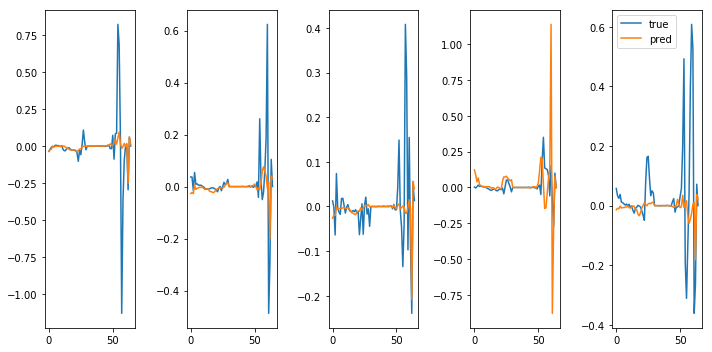

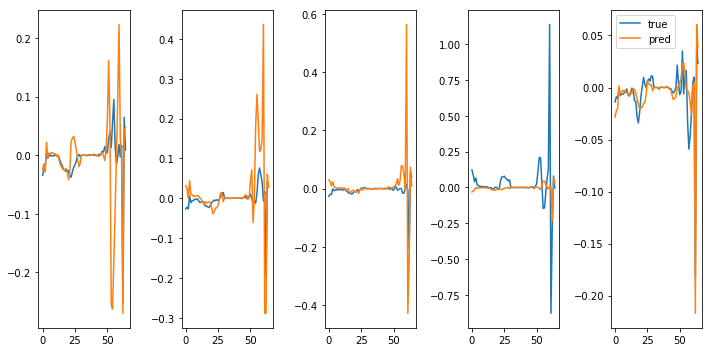

In [218]:
show_cbrain(true, preds, False)
show_cbrain(preds, preds2, False)